# ANÁLISE PREDITIVA - TIME SERIES ANALYTICS CLIMA

# 1. Introdução

O dataset analisado é relacionado a uma série de observações diárias de uma estação climática localizada na cidade de Jena, Alemanha. O dataset possui dados, formato de séries temporais, entre 2009 e 2016. O objetivo dessa análise preditiva é utilizar o algoritmo Prophet do núcleo de Ciência de Dados do Meta Facebook. 

Fonte dos dados: https://www.kaggle.com/datasets/mnassrib/jena-climate

# 2. Carga de dados e pacotes

In [100]:
# carregando os pacotes e removendo os avisos
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib import pylab
from prophet import Prophet
from datetime import datetime
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
base = pd.read_csv('jena_climate_2009_2016.csv')
base.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
# Verifica o shape da base
# São 420mil registros e 15 atributos
base.shape

(420551, 15)

In [4]:
# Resumo do dataset
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


Aqui já temos uma questão que são os tipos de dados, as variáveis preditoras são todas do tipo float64 o que está correto porque estamos tratando de medições de temperatura e pressão ambiente, por exemplo. Contudo, a primeira variável é do tipo DateTime e será feita a conversão na próxima célula para que seja possível realizar alguma análise exploratória.

Não há valores nulos no dataset.

In [5]:
# Converte coluna de data em DateTime
base['Date Time'] = pd.to_datetime(base["Date Time"])

In [6]:
# Confere os tipos de dados
base.dtypes

Date Time          datetime64[ns]
p (mbar)                  float64
T (degC)                  float64
Tpot (K)                  float64
Tdew (degC)               float64
rh (%)                    float64
VPmax (mbar)              float64
VPact (mbar)              float64
VPdef (mbar)              float64
sh (g/kg)                 float64
H2OC (mmol/mol)           float64
rho (g/m**3)              float64
wv (m/s)                  float64
max. wv (m/s)             float64
wd (deg)                  float64
dtype: object

# 3. Análise Exploratória

Para realizar as análises, e por conta do tamanho da base,será feito um agrupamento de algumas variáveis para visualizar um período mês/ano nos gráficos.

In [7]:
# Cópia do dataset original
df = base
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [9]:
# Cria variáveis para agrupamento de datas

# Variável Ano
df['year'] = df['Date Time'].dt.year

# Variável Mês
df['month'] = df['Date Time'].dt.month

#Variável Ano-Mês
df['month_year'] = df['Date Time'].dt.to_period('M')

In [10]:
# Data como index da base
df = df.set_index('Date Time')

In [11]:
# Confirma as alterações
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),year,month,month_year
Date Time,,,,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,2009,1,2009-01
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,2009,1,2009-01
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,2009,1,2009-01
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,2009,1,2009-01
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,2009,1,2009-01


Text(0.5, 0, ' ')

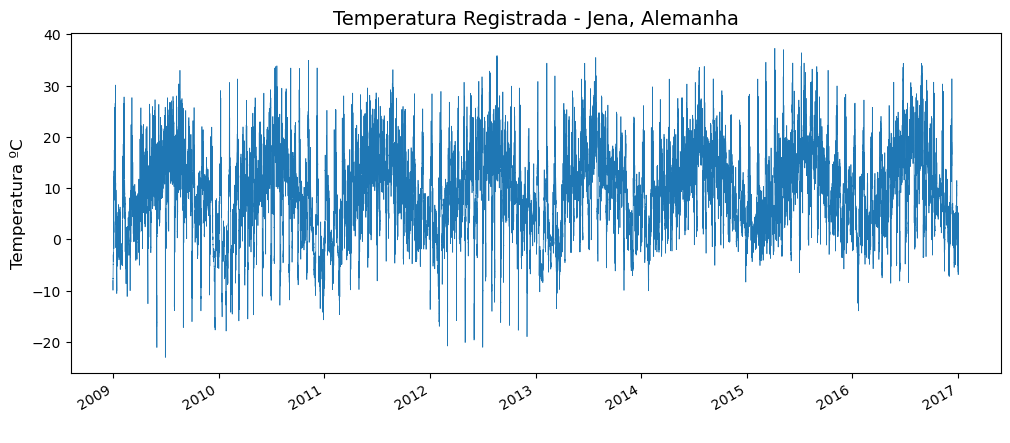

In [12]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df['T (degC)'].plot(linewidth=0.5)

# Define título
plt.title('Temperatura Registrada - Jena, Alemanha', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Temperatura ºC', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

Ao analisar as temperatuas ao longos dos anos mantém uma constante no geral, com períodos mais quentes e mais frios típicos da região de Jena. Chama a atenção o ano de 2012 que parece que foi o ano mais frio, com diversos períodos com temperaturas abaixo de -10ºC.

Por outro lado, vemos que no geral as temperaturas não ficaram mais abaixo de -10ºC. Na verdade, é possível observar que a faixa das temperaturas parece estar mais próxima dos 30ºC. 

Text(0.5, 0, ' ')

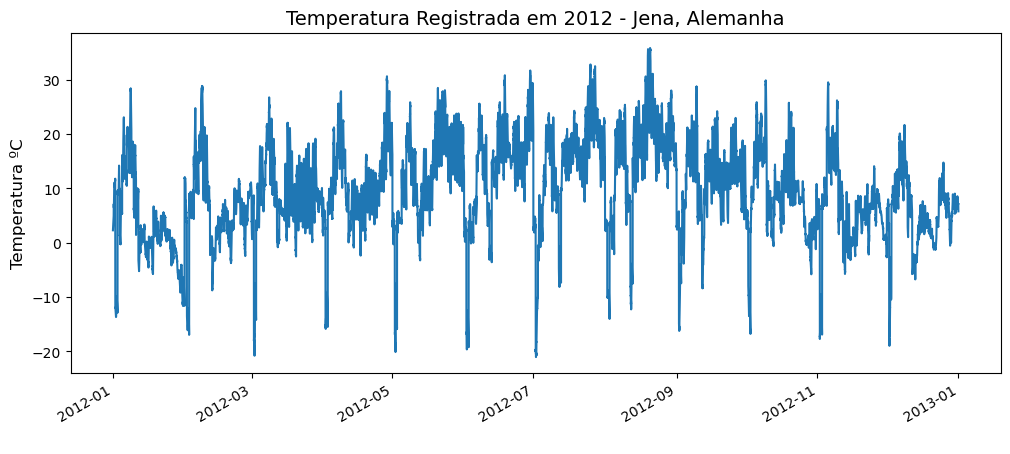

In [13]:
# Análise do ano de 2012
# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df.loc['2012', 'T (degC)'].plot()

# Define título
plt.title('Temperatura Registrada em 2012 - Jena, Alemanha', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Temperatura ºC', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

Algo que chama mais a atenção agora é que temos quedas muito bruscas de temperatura em poucos dias e ao longo de todo o ano, apesar do frio ser bem rigoroso na região, isso pode ter algumas explicações. 

Em teoria, uma delas poderia ser o local da medição de temperatura. Vale lembrar que na cidade de São Paulo temos uma diferença considerável entre medições na região da Sé (Centro) e Parelheiros (extremo da Zona Sul). Contudo, levando em consideração o tamanho das cidades, isso pode não fazer muito sentido sendo que Jena corresponde apenas 7,5% (114,29 Km²) da área da capital paulista. 

Uma outra opção poderia ser algum erro na medição desses valores, como um falha no equipamento neste dia. 

Text(0.5, 0, ' ')

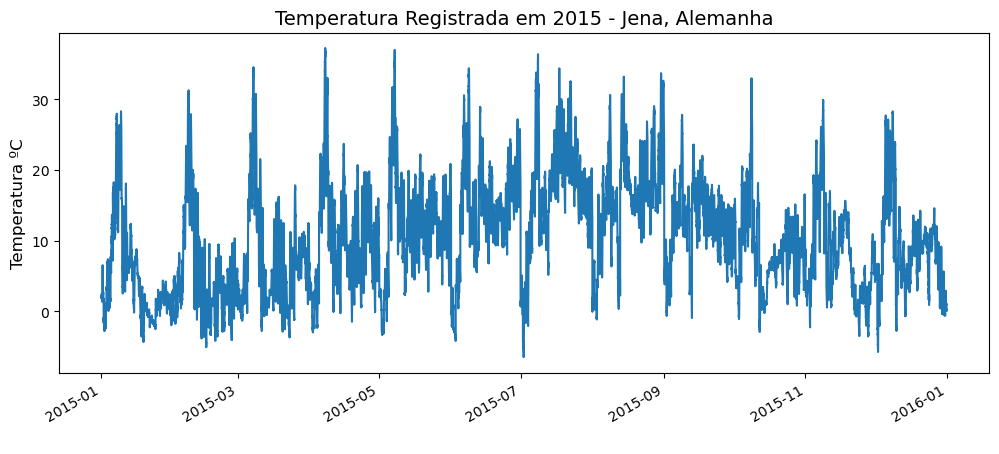

In [14]:
# Análise do ano de 2015
# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df.loc['2015', 'T (degC)'].plot()

# Define título
plt.title('Temperatura Registrada em 2015 - Jena, Alemanha', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Temperatura ºC', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

Neste recorte de 2015 temos uma variação um pouco mais próxima das temperaturas médias da cidade, com valore um pouco abaixo de 0 ºC, contudo chama a atenção algumas temperaturas acima de 30ºC em momentos que não comuns como no mês de Janeiro que é basicamente o meio do Inverno europeu.

Text(0, 0.5, 'sh (g/kg)')

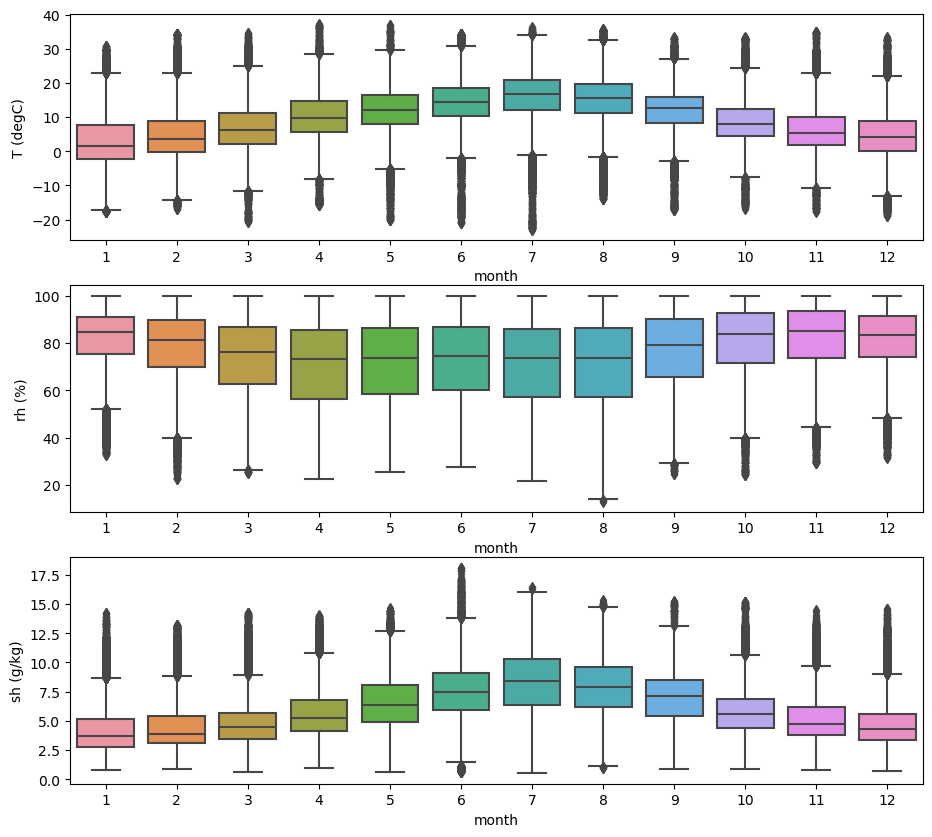

In [15]:
# Boxplot dos dados
# Ajuste no tamanho do gráfico
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=False)

# Plot com 3 variáveis
for name, ax in zip(['T (degC)', 'rh (%)', 'sh (g/kg)'], axes):

    sns.boxplot(data=df, x='month', y = name, ax = ax)

# Configura o eixo Y    
ax.set_ylabel(name)

Com o boxplot podemos ter uma noção mais clara do dados relacionados a temperatura ºC, umidade relativa e umidade especifica (g/kg). 

Em todas as variáveis, especialmente quando falamos de temperatura é possível observar uma série de outliers. Isso mostra que pode ser algo natural ou mesmo algum problema com o equipamento de medição. A temperatura possui um comportamento mais condizente com as estações da europa, e com valores mais consistentes sem considerar o outliers. 

O mesmo vemos com a umidade relativa, que tenha aumentar no verão europeu e diminuir no inverno. As variáveis também possuem um número alto de outliers fora do percentil 80%.

# 4. Pré-Processamento dos Dados

Nesta etapa da análise preditiva será feito a preparação do dataset para a aplicação do modelo preditivo de série temporal. O algorotimo Prophet aceita duas entradas, data e o atributo que terá as previsões. Nesse caso, além da data, vamos usar a temperatura em ºC para realizar as previsões no período, mas antes precisamos preparar o dataset.

In [55]:
# Cópia do dataset original
df_modelo = base[['Date Time', 'T (degC)']]

# Confere dataset e número de linhas
df_modelo

,Date Time,T (degC)
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27
...,...,...
420546,2016-12-31 23:20:00,-4.05
420547,2016-12-31 23:30:00,-3.35
420548,2016-12-31 23:40:00,-3.16
420549,2016-12-31 23:50:00,-4.23


In [56]:
# Renomeia colunas de data para ds e variável target para y
df_modelo.rename(
    columns={"Date Time": "ds", "T (degC)": "y"},
    inplace=True,
)

# Confere as mudanças no nome das colunas
df_modelo

,ds,y
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27
...,...,...
420546,2016-12-31 23:20:00,-4.05
420547,2016-12-31 23:30:00,-3.35
420548,2016-12-31 23:40:00,-3.16
420549,2016-12-31 23:50:00,-4.23


In [57]:
# Converte datetime em tipo date (yyyy-mm-dd)

df_modelo['ds'] = pd.to_datetime(df_modelo['ds']).dt.date

# Confere as mudanças e confirma o número de linhas
df_modelo

,ds,y
0,2009-01-01,-8.02
1,2009-01-01,-8.41
2,2009-01-01,-8.51
3,2009-01-01,-8.31
4,2009-01-01,-8.27
...,...,...
420546,2016-12-31,-4.05
420547,2016-12-31,-3.35
420548,2016-12-31,-3.16
420549,2016-12-31,-4.23


In [58]:
# Group by pela média da temperatura em Cº
df_modelo = df_modelo.groupby(['ds'])['y'].mean()

# Confere o novo dataset
df_modelo

ds
2009-01-01    -6.810629
2009-01-02    -3.360486
2009-01-03     5.435694
2009-01-04     7.283889
2009-01-05    12.690069
                ...    
2016-12-28     4.887153
2016-12-29     2.676250
2016-12-30    -1.706597
2016-12-31    -2.492500
2017-01-01    -4.820000
Name: y, Length: 2921, dtype: float64

In [59]:
# Converte o objeto em dataframe pandas
df_modelo = pd.DataFrame(df_modelo)
df_modelo

,y
ds,
2009-01-01,-6.810629
2009-01-02,-3.360486
2009-01-03,5.435694
2009-01-04,7.283889
2009-01-05,12.690069
...,...
2016-12-28,4.887153
2016-12-29,2.676250
2016-12-30,-1.706597


In [60]:
df_modelo = df_modelo.reset_index()
df_modelo

,ds,y
0,2009-01-01,-6.810629
1,2009-01-02,-3.360486
2,2009-01-03,5.435694
3,2009-01-04,7.283889
4,2009-01-05,12.690069
...,...,...
2916,2016-12-28,4.887153
2917,2016-12-29,2.676250
2918,2016-12-30,-1.706597
2919,2016-12-31,-2.492500


In [61]:
# Confere coluna y e seu nome
list(df_modelo.columns)

['ds', 'y']

Text(0, 0.5, 'Temperatura ºC')

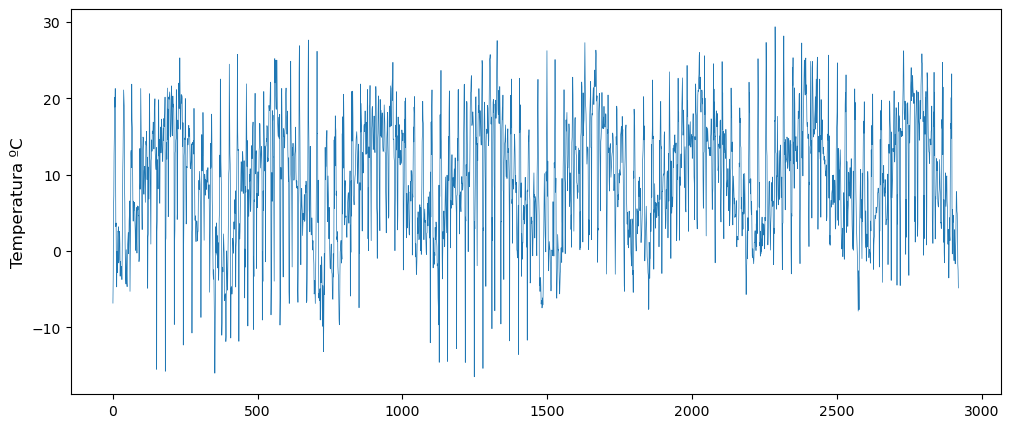

In [64]:
# Boxplot dos dados da temperatura em ºC
# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Cria plot
df_modelo['y'].plot(linewidth=0.5)

# Define nomes dos eixos X e Y
plt.ylabel('Temperatura ºC', fontsize = 12)

O modelo do Prophet lida bem com outliers, por isso eles não serão removidos. Uma alternativa seria filtrar pelo z-score. 

# 5. Modelo Preditivo - Prophet

In [65]:
# Cria o modelo prophet como objeto python
m = Prophet()

In [67]:
# Fit do modelo
m.fit(df_modelo)

21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
# Prepara o dataset com input das datas com as previsões
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3281,2017-12-28
3282,2017-12-29
3283,2017-12-30
3284,2017-12-31
3285,2018-01-01


In [69]:
# Previsões com o Prophet
forecast = m.predict(future)

In [70]:
# Visualiza as últimas previsões
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3281,2017-12-28,6.109519,-2.596289,14.800654
3282,2017-12-29,6.321383,-2.715884,14.651144
3283,2017-12-30,6.106578,-2.634151,14.308786
3284,2017-12-31,6.041194,-2.772161,14.421858
3285,2018-01-01,6.122966,-2.137569,15.003861


# 6. Análise dos Resultados

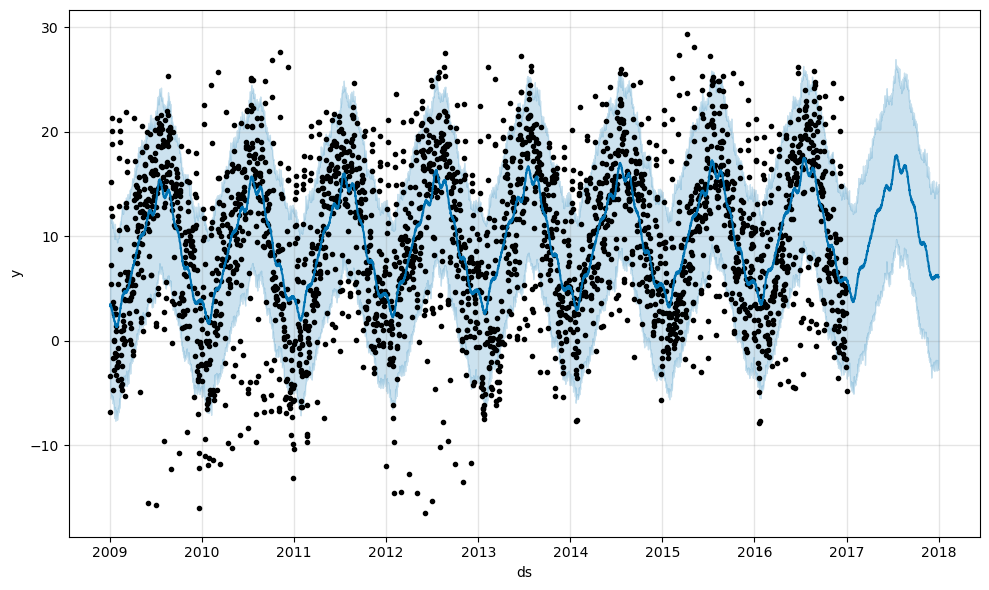

In [71]:
# Plot do modelo
fig1 = m.plot(forecast)

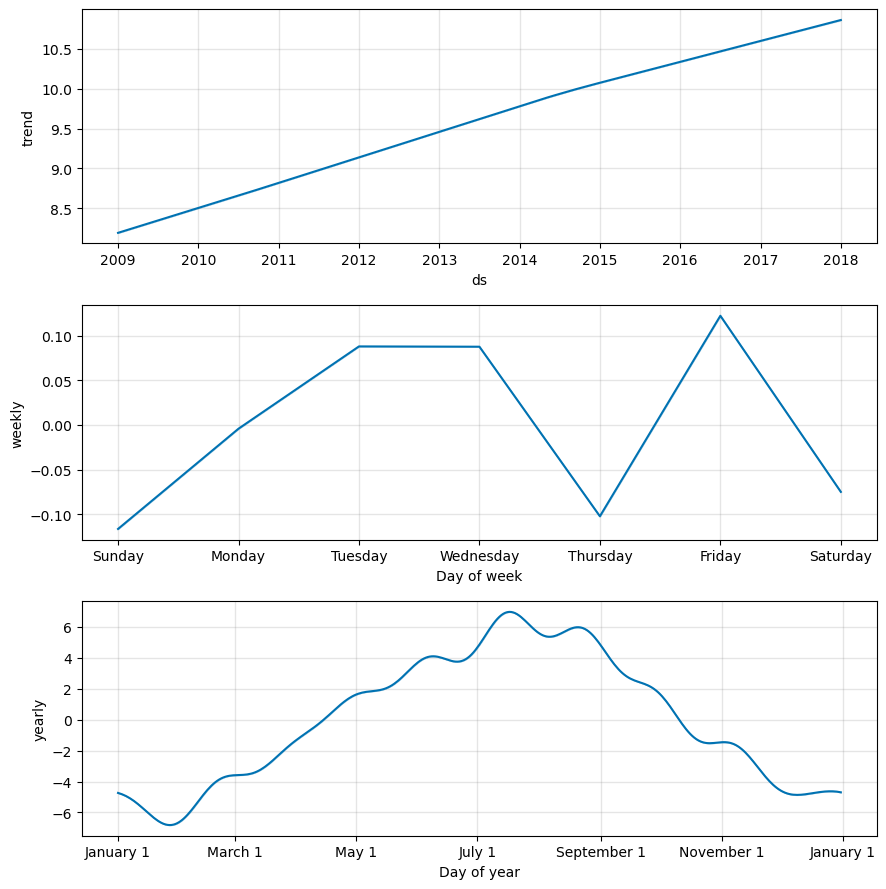

In [72]:
# Plot dos components
fig2 = m.plot_components(forecast)

In [95]:
# Prepara para Cross Validation no Prophet
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/11 [00:00<?, ?it/s]

21:39:37 - cmdstanpy - INFO - Chain [1] start processing
21:39:37 - cmdstanpy - INFO - Chain [1] done processing
21:39:37 - cmdstanpy - INFO - Chain [1] start processing
21:39:38 - cmdstanpy - INFO - Chain [1] done processing
21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:38 - cmdstanpy - INFO - Chain [1] done processing
21:39:39 - cmdstanpy - INFO - Chain [1] start processing
21:39:39 - cmdstanpy - INFO - Chain [1] done processing
21:39:40 - cmdstanpy - INFO - Chain [1] start processing
21:39:40 - cmdstanpy - INFO - Chain [1] done processing
21:39:40 - cmdstanpy - INFO - Chain [1] start processing
21:39:40 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:42 - cmdstanpy - INFO - Chain [1] start processing
21:39:42 - cmdstanpy - INFO - Chain [1] done processing
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1]

In [96]:
# Dataset com o Cross Validation
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-01-29,-1.725368,-9.859123,8.133994,-5.756319,2011-01-28
1,2011-01-30,-1.224791,-9.441736,7.528258,-6.296736,2011-01-28
2,2011-01-31,-1.569987,-10.168499,7.680105,-6.309444,2011-01-28
3,2011-02-01,-1.240401,-9.749478,8.091769,-0.353681,2011-01-28
4,2011-02-02,-1.755368,-10.641478,7.689082,-3.387847,2011-01-28


In [97]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,53.203961,7.294105,5.713414,3.070528,0.469431,0.838953,0.768307
1,38 days,52.921684,7.274729,5.691190,3.018407,0.462586,0.833834,0.772161
2,39 days,54.314566,7.369842,5.758453,3.134842,0.457156,0.837804,0.769440
3,40 days,54.391396,7.375052,5.749091,3.434994,0.457156,0.832401,0.772161
4,41 days,53.822328,7.336370,5.712818,3.504835,0.462586,0.829977,0.777148


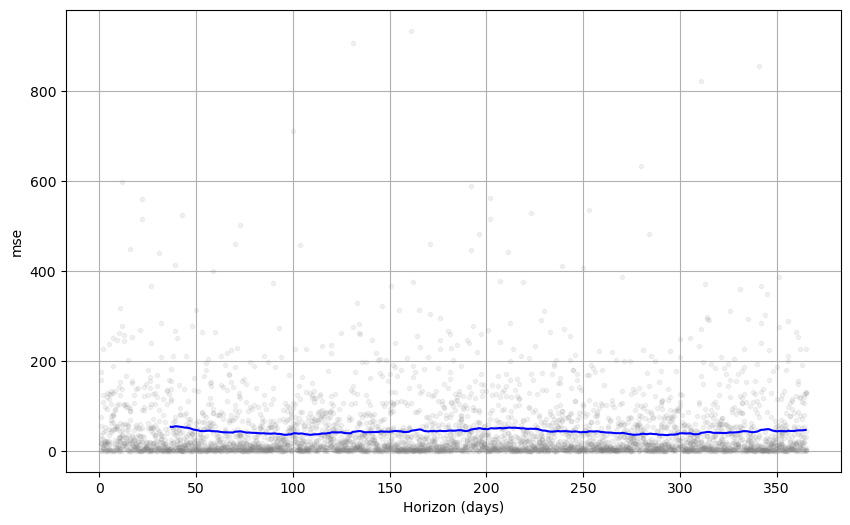

In [99]:
fig = plot_cross_validation_metric(df_cv, metric='mse')

# 7. Tunning do Modelo

In [104]:
# 
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])

In [105]:
# 
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_modelo)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs = cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

21:44:07 - cmdstanpy - INFO - Chain [1] start processing
21:44:07 - cmdstanpy - INFO - Chain [1] done processing
21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:13 - cmdstanpy - INFO - Chain [1] done processing
21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing
21:44:28 - cmdstanpy - INFO - Chain [1] start processing
21:44:29 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:40 - cmdstanpy - INFO - Chain [1] start processing
21:44:40 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] done processing
21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  6.978559
1                     0.001                     0.10  6.516300
2                     0.001                     1.00  6.565932
3                     0.001                    10.00  6.750570
4                     0.010                     0.01  7.033842
5                     0.010                     0.10  6.622273
6                     0.010                     1.00  6.590116
7                     0.010                    10.00  6.596847
8                     0.100                     0.01  6.954459
9                     0.100                     0.10  6.636601
10                    0.100                     1.00  6.640269
11                    0.100                    10.00  6.642774
12                    0.500                     0.01  6.657396
13                    0.500                     0.10  6.505041
14                    0.500                     1.00  6

In [106]:
# 
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}


# 8. Modelo v2

# 9. Análise dos Resultados do Modelo v2

# 10. Considerações Finais

Contudo, se por um lado tem um preocupação a menos com outliers... por outro temos o problema de uma única entrada que é a variável preditora. Em caso de outras variáveis no modelo, é necessário usar algoritmos com redes neurais, por exemplo.